This project is an introduction to artificial neural nets: fully-connected
neural nets, hidden layers, activation functions, back-propagation, dropout.

### Implementation Steps:
1. **Setup:** Create a Jupyter notebook environment and import necessary libraries.
2. **Data Exploration and Preprocessing:** Load the dataset, perform exploratory data analysis, handle missing values, and perform feature engineering.
3. **Model Development:** Implement various models as specified in the mandatory part.
4. **Evaluation:** Compare models based on accuracy and AUC, and create a summary table.
5. **Optimization:** Work on the bonus part to enhance model performance.
6. **Finalization:** Prepare the submission file and documentation for peer review.

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV). The objective is to predict the value in one column based on the values in the other columns.

## 1. Setup

In [5]:
%%capture
! pip install -Uqq fastbook dtreeviz
! pip install keras_tuner


import fastbook
fastbook.setup_book()

import numpy as np
import pandas as pd

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import dtreeviz
import pickle

from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
random_state = 123
import warnings
warnings.filterwarnings('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
def update_summary_table(approach, lib, accuracy, auc):

    baseline_index = summary_table[summary_table['Approach'] == approach].index

    summary_table.loc[baseline_index, 'Library Used'] = lib
    summary_table.loc[baseline_index, 'Accuracy'] = accuracy
    summary_table.loc[baseline_index, 'AUC Score'] = auc
    return summary_table

summary_table = pd.DataFrame({
    "Approach": ["Baseline (Naive Classifier)", "Random Forest", "Scikit-learn (MLPClassifier)",
                 "Keras (TensorFlow)", "TensorFlow", "NumPy"],
    "Library Used": ["None", "Scikit-learn", "Scikit-learn", "TensorFlow", "TensorFlow", "NumPy"],
    "Algorithm": ["Naive Classifier", "Random Forest", "MLPClassifier", "Keras Neural Network",
                  "TensorFlow Neural Network", "Custom Neural Network"],
    "Hyperparameters": ["N/A", "Optimized via Grid Search", "Default / Custom Settings",
                        "Custom Settings", "Custom Settings", "Custom Implementation"],
    "Accuracy": ["To be filled", "To be filled", "To be filled", "To be filled", "To be filled", "To be filled"],
    "AUC Score": ["To be filled", "To be filled", "To be filled", "To be filled", "To be filled", "To be filled"]
})



summary_table

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),None,Naive Classifier,N/A,To be filled,To be filled
1,Random Forest,Scikit-learn,Random Forest,Optimized via Grid Search,To be filled,To be filled
2,Scikit-learn (MLPClassifier),Scikit-learn,MLPClassifier,Default / Custom Settings,To be filled,To be filled
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,To be filled,To be filled
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,To be filled,To be filled
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


## 2. Data Exploration and Preprocessing

- Download and prepare the dataset.
- Perform data preprocessing, such as handling missing values and feature selection.
- Split the dataset into training and testing sets with stratification.

In tabular data some columns may contain numerical data, like "age," while others contain string values, like "sex." The numerical data can be directly fed to the model (with some optional preprocessing), but the other columns need to be converted to numbers. Since the values in those correspond to different categories, we often call this type of variables categorical variables. The first type are called continuous variables.

In [13]:
file_path =  'drive/MyDrive/cursus/churn/data'
df = pd.read_csv(f'{file_path}/bank_data_train.csv', low_memory=False)
# file_path = 'data/bank_data_train.csv'
# df = pd.read_csv(file_path, low_memory=False)

df.head()

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,PRC_ACCEPTS_A_EMAIL_LINK,APP_REGISTR_RGN_CODE,PRC_ACCEPTS_A_POS,PRC_ACCEPTS_A_TK,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,PRC_ACCEPTS_A_AMOBILE,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,PRC_ACCEPTS_TK,PRC_ACCEPTS_A_MTP,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,CNT_ACCEPTS_TK,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,PRC_ACCEPTS_A_ATM,PRC_ACCEPTS_MTP,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CNT_ACCEPTS_MTP,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.541683,0,156067.339767,NaN,NaN,NaN,0.0,начальник отдела,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,1.000000,1.000000,0.0,660,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.134651,0.0,NaN,NaN,NaN,0.0,0.474134,NaN,0.131910,0.0,NaN,0.0,0.406780,0.101695,0.0,0.483032,NaN,NaN,NaN,NaN,NaN,0.134634,0.0,NaN,NaN,0.442285,K01,NaN,NaN,1.593023,NaN,0.0,NaN,0.0,NaN,0.483032,NaN,0.406780,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,NaN,NaN,NaN,0.0,0.166667,0.186107,0.244678,NaN,0.670968,NaN,NaN,NaN,0.0,0.666667,NaN,NaN,0.000000,0,4278.845817,NaN,NaN,NaN,0.0,NaN,NaN,0.454545,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,0,NaN,NaN,0.0,0.109091,0.410691,0.0,552,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239365,0.0,NaN,NaN,NaN,0.0,0.384264,0.6,0.101934,0.0,0.510712,0.0,0.333333,0.166667,0.0,0.200000,NaN,NaN,NaN,0.309799,NaN,0.133333,0.0,0.24,NaN,0.515876,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.394340,NaN,0.545455,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.000000,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.000000,0,112837.062817,NaN,NaN,NaN,0.0,ГЕНЕРАЛЬНЫЙ ДИРЕКТОР,NaN,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0,NaN,0,NaN,NaN,0.0,0.810811,0.925140,0.0,420,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.084341,0.0,NaN,NaN,NaN,0.0,0.336136,NaN,0.121041,0.0,NaN,0.0,0.366667,0.133333,0.0,0.431656,NaN,NaN,NaN,NaN,NaN,0.063129,0.0,NaN,NaN,0.522833,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.399342,NaN,0.297297,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.00

In [14]:
len(df.columns)

116

In [15]:
constant_or_nan_cols = [col for col in df.columns if df[col].nunique(dropna=True) <= 1]
df.drop(columns=constant_or_nan_cols, inplace=True)
constant_or_nan_cols

['PRC_ACCEPTS_A_EMAIL_LINK',
 'PRC_ACCEPTS_A_POS',
 'PRC_ACCEPTS_A_TK',
 'PRC_ACCEPTS_A_AMOBILE',
 'PRC_ACCEPTS_TK',
 'PRC_ACCEPTS_A_MTP',
 'CNT_ACCEPTS_TK',
 'PRC_ACCEPTS_A_ATM',
 'PRC_ACCEPTS_MTP',
 'CNT_ACCEPTS_MTP']

In [16]:
len(df.columns)

106

In [17]:
df[df.select_dtypes(include=["object"]).columns] = df.select_dtypes(include=["object"]).apply(lambda c: c.str.lower())

In [18]:
df

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146841,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.541683,0,156067.339767,NaN,NaN,NaN,0.000000,начальник отдела,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,0,NaN,0,NaN,NaN,0.0,1.000000,1.000000,0.0,660,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.134651,0.0,NaN,NaN,NaN,0.0,0.474134,NaN,0.131910,0.0,NaN,0.0,0.406780,0.101695,0.0,0.483032,NaN,NaN,NaN,NaN,NaN,0.134634,0.0,NaN,NaN,0.442285,k01,NaN,NaN,1.593023,NaN,0.0,NaN,0.0,NaN,0.483032,NaN,0.406780,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
1,146842,0,0.041033,NaN,0.0,0.166667,0.186107,0.244678,0.670968,NaN,0.0,0.666667,NaN,0.000000,0,4278.845817,NaN,NaN,NaN,0.000000,NaN,NaN,0.454545,NaN,NaN,NaN,0.000000,NaN,0,NaN,0,NaN,NaN,0.0,0.109091,0.410691,0.0,552,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239365,0.0,NaN,NaN,NaN,0.0,0.384264,0.600000,0.101934,0.0,0.510712,0.0,0.333333,0.166667,0.0,0.200000,NaN,NaN,NaN,0.309799,NaN,0.133333,0.0,0.240000,NaN,0.515876,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.394340,NaN,0.545455,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
2,146843,0,0.006915,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,112837.062817,NaN,NaN,NaN,0.000000,генеральный директор,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,0,NaN,0,NaN,NaN,0.0,0.810811,0.925140,0.0,420,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.084341,0.0,NaN,NaN,NaN,0.0,0.336136,NaN,0.121041,0.0,NaN,0.0,0.366667,0.133333,0.0,0.431656,NaN,NaN,NaN,NaN,NaN,0.063129,0.0,NaN,NaN,0.522833,102,NaN,NaN,1.587647,NaN,0.0,NaN,0.0,NaN,0.399342,NaN,0.297297,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
3,146844,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.005874,0,42902.902883,NaN,NaN,NaN,0.000000,менеджер иао,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,0,NaN,0,NaN,NaN,0.0,1.000000,1.000000,0.0,372,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.005659,0.0,NaN,

In [19]:
translation_dict = {
    'близкий ро': 'close relative', 'друг': 'friend', 'отец': 'father',
    'сестра': 'sister', 'сын': 'son', 'мать': 'mother', 'муж': 'husband',
    'брат': 'brother', 'дальний ро': 'distant relative', 'дочь': 'daughter',
    'жена': 'wife', 'mother': 'mother', 'brother': 'brother', 'friend': 'friend',
    'sister': 'sister', 'other': 'other', 'relative': 'relative', 'daughter': 'daughter',
    'son': 'son', 'father': 'father'
}

df['CLNT_TRUST_RELATION'] = df['CLNT_TRUST_RELATION'].map(translation_dict)
df['CLNT_TRUST_RELATION'].unique()

array([nan, 'mother', 'brother', 'friend', 'sister', 'other', 'relative', 'daughter', 'son', 'father', 'close relative', 'husband', 'distant relative', 'wife'], dtype=object)

In [20]:
majority_class = df['TARGET'].value_counts().idxmax()
majority_class

0

In [21]:
# Filter the DataFrame to keep only rows with the minority class
# df_filtered = df[df['TARGET'] != majority_class]
df_filtered_0 = df[df['TARGET'] == majority_class]
df_filtered_0['TARGET'].value_counts()

0    326265
Name: TARGET, dtype: int64

In [22]:
df_filtered_0.shape

(326265, 106)

In [23]:
threshold = 52  # Adjust this threshold based on your requirements
df_filtered_0 = df_filtered_0.dropna(thresh=df_filtered_0.shape[1] - threshold + 1)
df_filtered_0

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
1,146842,0,0.041033,NaN,0.0,0.166667,0.186107,0.244678,0.670968,NaN,0.0,0.666667,NaN,0.0,0,4278.845817,NaN,NaN,NaN,0.000000,NaN,NaN,0.454545,NaN,NaN,NaN,0.000000,NaN,0,NaN,0,NaN,NaN,0.0,0.109091,0.410691,0.000000,552,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.239365,0.000000,NaN,NaN,NaN,0.0,0.384264,0.600000,0.101934,0.000000,0.510712,0.0,0.333333,0.166667,0.0,0.200000,NaN,NaN,NaN,0.309799,NaN,0.133333,0.000000,0.240000,NaN,0.515876,102,NaN,NaN,1.587647,NaN,0.000000,NaN,0.000000,NaN,0.394340,NaN,0.545455,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
5,146846,0,0.077010,NaN,0.0,0.500000,0.098136,0.050708,1.000000,NaN,0.0,1.000000,NaN,0.0,0,0.000000,NaN,NaN,NaN,0.008501,NaN,NaN,0.207547,NaN,0.250000,NaN,0.113208,NaN,0,NaN,0,0.345196,NaN,0.0,0.226415,0.767778,248361.558333,384,NaN,0,NaN,0.0,0.0,NaN,0.649373,NaN,NaN,0,NaN,NaN,NaN,0.500000,0.000000,105180.487383,NaN,NaN,NaN,0.0,0.000000,0.727273,0.000000,0.657494,0.627798,0.0,0.500000,0.166667,0.0,0.854130,NaN,NaN,NaN,0.110611,NaN,0.018453,0.023562,0.181818,NaN,0.000000,105,NaN,NaN,1.593023,NaN,0.700485,NaN,0.033022,NaN,0.780661,NaN,0.698113,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
8,146850,0,0.017322,NaN,0.0,0.333333,0.357143,0.002935,0.357143,NaN,0.0,0.333333,NaN,0.0,0,116791.222983,NaN,NaN,NaN,0.000000,генеральный директор,NaN,0.020408,NaN,NaN,NaN,0.000000,NaN,2,NaN,0,NaN,NaN,0.0,0.448980,0.751444,0.000000,492,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.707973,0.000000,NaN,NaN,NaN,0.0,0.771877,NaN,0.911780,0.000000,NaN,0.0,0.272727,0.045455,0.0,0.353191,0.0,NaN,20.00,NaN,45.00,0.015648,0.000000,NaN,0.0,0.937303,o01,NaN,NaN,1.590335,0.0,0.000000,NaN,0.000000,NaN,0.297416,NaN,0.326531,NaN,0.0,1.0,0.0,NaN,0.001976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,146851,0,0.067036,NaN,0.0,NaN,NaN,0.426053,NaN,NaN,0.0,NaN,NaN,0.0,0,51312.385183,0.300,NaN,NaN,0.000000,архитектор,Na

In [24]:
df_filtered_1 = df[df['TARGET'] != majority_class]
df_filtered_1

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
26,146871,0,0.020267,NaN,0.0,1.0,1.000000,0.111424,1.000000,mother,0.0,1.000000,NaN,0.994683,0,1049.544317,NaN,NaN,NaN,0.000000,NaN,NaN,0.379310,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,0.000000,0.000000,0.000000,624,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.548043,0.000000,NaN,NaN,NaN,0.0,0.597867,0.363636,0.375444,0.000000,0.218070,0.0,NaN,NaN,0.0,NaN,0.0,NaN,20.00,0.218070,20.0,NaN,0.000000,0.363636,0.0,0.787479,o01,NaN,NaN,2.101087,0.0,0.000000,NaN,0.000000,NaN,0.655993,NaN,0.551724,NaN,0.0,1.0,0.0,NaN,0.479087,0.0,1.0,0.615412,0.615412,0.5,0.0,0.233333,0.233333,0.233333,1
27,146872,0,0.000000,NaN,0.0,NaN,NaN,0.016017,NaN,friend,0.0,NaN,NaN,0.000000,0,372.021867,NaN,NaN,NaN,0.000000,водитель-экспедитор,NaN,0.333333,NaN,NaN,NaN,0.000000,NaN,2,NaN,0,NaN,NaN,0.0,0.666667,0.983983,0.000000,276,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.508451,0.000000,NaN,NaN,NaN,0.0,0.929992,1.000000,0.366414,0.000000,1.000000,0.0,0.900000,0.500000,0.0,0.975369,0.0,NaN,45.00,1.000000,45.0,0.369458,0.000000,1.000000,0.0,0.951984,102,NaN,NaN,2.079582,0.0,0.000000,NaN,0.000000,NaN,0.975764,NaN,0.933333,NaN,0.0,1.0,0.0,NaN,0.073967,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1
30,146875,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,50349.755383,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,1.000000,1.000000,503.430000,444,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.259187,0.000000,NaN,NaN,NaN,0.0,0.978182,NaN,0.389747,0.000000,NaN,0.0,1.000000,0.277778,0.0,1.000000,0.0,NaN,20.00,NaN,20.0,0.394616,0.000000,NaN,0.0,0.998822,k01,NaN,NaN,1.528507,0.0,0.630223,NaN,0.609817,NaN,1.000000,NaN,1.000000,NaN,0.0,1.0,0.0,NaN,0.223881,0.0,1.0,0.430108,0.430108,0.0,0.0,0.000000,0.000000,0.000000,1
59,146914,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,0.000000,NaN,NaN,NaN,0

In [25]:
X =  pd.concat([df_filtered_1, df_filtered_0], axis=0).reset_index(drop=True)
X

,ID,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,146871,0,0.020267,NaN,0.0,1.000000,1.000000,0.111424,1.000000,mother,0.0,1.000000,NaN,0.994683,0,1049.544317,NaN,NaN,NaN,0.000000,NaN,NaN,0.379310,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,0.000000,0.000000,0.000000,624,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.548043,0.000000,NaN,NaN,NaN,0.0,0.597867,0.363636,0.375444,0.000000,0.218070,0.0,NaN,NaN,0.0,NaN,0.0,NaN,20.00,0.218070,20.00,NaN,0.000000,0.363636,0.0,0.787479,o01,NaN,NaN,2.101087,0.0,0.000000,NaN,0.000000,NaN,0.655993,NaN,0.551724,NaN,0.0,1.0,0.0,NaN,0.479087,0.0,1.0,0.615412,0.615412,0.5,0.0,0.233333,0.233333,0.233333,1
1,146872,0,0.000000,NaN,0.0,NaN,NaN,0.016017,NaN,friend,0.0,NaN,NaN,0.000000,0,372.021867,NaN,NaN,NaN,0.000000,водитель-экспедитор,NaN,0.333333,NaN,NaN,NaN,0.000000,NaN,2,NaN,0,NaN,NaN,0.0,0.666667,0.983983,0.000000,276,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.508451,0.000000,NaN,NaN,NaN,0.0,0.929992,1.000000,0.366414,0.000000,1.000000,0.0,0.900000,0.500000,0.0,0.975369,0.0,NaN,45.00,1.000000,45.00,0.369458,0.000000,1.000000,0.0,0.951984,102,NaN,NaN,2.079582,0.0,0.000000,NaN,0.000000,NaN,0.975764,NaN,0.933333,NaN,0.0,1.0,0.0,NaN,0.073967,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1
2,146875,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,50349.755383,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,1.000000,1.000000,503.430000,444,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.259187,0.000000,NaN,NaN,NaN,0.0,0.978182,NaN,0.389747,0.000000,NaN,0.0,1.000000,0.277778,0.0,1.000000,0.0,NaN,20.00,NaN,20.00,0.394616,0.000000,NaN,0.0,0.998822,k01,NaN,NaN,1.528507,0.0,0.630223,NaN,0.609817,NaN,1.000000,NaN,1.000000,NaN,0.0,1.0,0.0,NaN,0.223881,0.0,1.0,0.430108,0.430108,0.0,0.0,0.000000,0.000000,0.000000,1
3,146914,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,0.000000,NaN,NaN,N

In [26]:
X.pop('ID')
X

,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,CLNT_TRUST_RELATION,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,APP_MARITAL_STATUS,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,AMOUNT_RUB_NAS_PRC,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,TRANS_COUNT_SUP_PRC,APP_EDUCATION,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,APP_TRAVEL_PASS,CR_PROD_CNT_TOVR,APP_CAR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,APP_POSITION_TYPE,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,APP_EMP_TYPE,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,APP_COMP_TYPE,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,PACK,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
0,0,0.020267,NaN,0.0,1.000000,1.000000,0.111424,1.000000,mother,0.0,1.000000,NaN,0.994683,0,1049.544317,NaN,NaN,NaN,0.000000,NaN,NaN,0.379310,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,0.000000,0.000000,0.000000,624,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.548043,0.000000,NaN,NaN,NaN,0.0,0.597867,0.363636,0.375444,0.000000,0.218070,0.0,NaN,NaN,0.0,NaN,0.0,NaN,20.00,0.218070,20.00,NaN,0.000000,0.363636,0.0,0.787479,o01,NaN,NaN,2.101087,0.0,0.000000,NaN,0.000000,NaN,0.655993,NaN,0.551724,NaN,0.0,1.0,0.0,NaN,0.479087,0.0,1.0,0.615412,0.615412,0.5,0.0,0.233333,0.233333,0.233333,1
1,0,0.000000,NaN,0.0,NaN,NaN,0.016017,NaN,friend,0.0,NaN,NaN,0.000000,0,372.021867,NaN,NaN,NaN,0.000000,водитель-экспедитор,NaN,0.333333,NaN,NaN,NaN,0.000000,NaN,2,NaN,0,NaN,NaN,0.0,0.666667,0.983983,0.000000,276,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.508451,0.000000,NaN,NaN,NaN,0.0,0.929992,1.000000,0.366414,0.000000,1.000000,0.0,0.900000,0.500000,0.0,0.975369,0.0,NaN,45.00,1.000000,45.00,0.369458,0.000000,1.000000,0.0,0.951984,102,NaN,NaN,2.079582,0.0,0.000000,NaN,0.000000,NaN,0.975764,NaN,0.933333,NaN,0.0,1.0,0.0,NaN,0.073967,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1
2,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,50349.755383,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,NaN,1,NaN,0,NaN,NaN,0.0,1.000000,1.000000,503.430000,444,NaN,0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,0.259187,0.000000,NaN,NaN,NaN,0.0,0.978182,NaN,0.389747,0.000000,NaN,0.0,1.000000,0.277778,0.0,1.000000,0.0,NaN,20.00,NaN,20.00,0.394616,0.000000,NaN,0.0,0.998822,k01,NaN,NaN,1.528507,0.0,0.630223,NaN,0.609817,NaN,1.000000,NaN,1.000000,NaN,0.0,1.0,0.0,NaN,0.223881,0.0,1.0,0.430108,0.430108,0.0,0.0,0.000000,0.000000,0.000000,1
3,0,0.000000,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,0.0,NaN,NaN,0.000000,0,0.000000,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,Na

In [27]:
procs = [Categorify, FillMissing, Normalize]
y_names = 'TARGET'
cont_names, cat_names = cont_cat_split(X, 1, dep_var=y_names)
y_block = CategoryBlock()
splits = RandomSplitter(valid_pct=0.2)(range_of(X))

In [28]:
cont_len, cat_len = len(cont_names), len(cat_names)
cont_len, cat_len

(91, 13)

In [29]:
to = TabularPandas(X, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)
to.show()

,CLNT_TRUST_RELATION,APP_MARITAL_STATUS,APP_KIND_OF_PROP_HABITATION,CLNT_JOB_POSITION_TYPE,CLNT_JOB_POSITION,APP_DRIVING_LICENSE,APP_EDUCATION,APP_TRAVEL_PASS,APP_CAR,APP_POSITION_TYPE,APP_EMP_TYPE,APP_COMP_TYPE,PACK,AMOUNT_RUB_CLO_PRC_na,APP_REGISTR_RGN_CODE_na,CNT_TRAN_AUT_TENDENCY1M_na,SUM_TRAN_AUT_TENDENCY1M_na,AMOUNT_RUB_SUP_PRC_na,SUM_TRAN_AUT_TENDENCY3M_na,CNT_TRAN_AUT_TENDENCY3M_na,CNT_TRAN_MED_TENDENCY1M_na,AMOUNT_RUB_NAS_PRC_na,TRANS_COUNT_SUP_PRC_na,CNT_TRAN_CLO_TENDENCY1M_na,SUM_TRAN_MED_TENDENCY1M_na,TRANS_COUNT_NAS_PRC_na,SUM_TRAN_CLO_TENDENCY1M_na,TRANS_COUNT_ATM_PRC_na,AMOUNT_RUB_ATM_PRC_na,CNT_TRAN_MED_TENDENCY3M_na,SUM_TRAN_MED_TENDENCY3M_na,SUM_TRAN_CLO_TENDENCY3M_na,LDEAL_TENOR_MAX_na,LDEAL_YQZ_CHRG_na,DEAL_YQZ_IR_MAX_na,LDEAL_YQZ_COM_na,DEAL_YQZ_IR_MIN_na,CNT_TRAN_CLO_TENDENCY3M_na,LDEAL_TENOR_MIN_na,LDEAL_AMT_MONTH_na,CNT_TRAN_SUP_TENDENCY3M_na,SUM_TRAN_SUP_TENDENCY3M_na,CNT_TRAN_ATM_TENDENCY3M_na,CNT_TRAN_ATM_TENDENCY1M_na,SUM_TRAN_ATM_TENDENCY3M_na,DEAL_GRACE_DAYS_ACC_S1X1_na,AVG_PCT_MONTH_TO_PCLOSE_na,DEAL_YWZ_IR_MIN_na,SUM_TRAN_SUP_TENDENCY1M_na,DEAL_YWZ_IR_MAX_na,SUM_TRAN_ATM_TENDENCY1M_na,CNT_TRAN_SUP_TENDENCY1M_na,DEAL_GRACE_DAYS_ACC_AVG_na,MAX_PCLOSE_DATE_na,LDEAL_YQZ_PC_na,DEAL_GRACE_DAYS_ACC_MAX_na,LDEAL_DELINQ_PER_MAXYQZ_na,CLNT_SALARY_VALUE_na,TRANS_AMOUNT_TENDENCY3M_na,MED_DEBT_PRC_YQZ_na,TRANS_CNT_TENDENCY3M_na,LDEAL_USED_AMT_AVG_YQZ_na,LDEAL_USED_AMT_AVG_YWZ_na,AVG_PCT_DEBT_TO_DEAL_AMT_na,LDEAL_ACT_DAYS_ACC_PCT_AVG_na,MED_DEBT_PRC_YWZ_na,LDEAL_ACT_DAYS_PCT_TR3_na,LDEAL_ACT_DAYS_PCT_AAVG_na,LDEAL_DELINQ_PER_MAXYWZ_na,LDEAL_ACT_DAYS_PCT_TR_na,LDEAL_ACT_DAYS_PCT_TR4_na,LDEAL_ACT_DAYS_PCT_CURR_na,CR_PROD_CNT_IL,AMOUNT_RUB_CLO_PRC,APP_REGISTR_RGN_CODE,TURNOVER_DYNAMIC_IL_1M,CNT_TRAN_AUT_TENDENCY1M,SUM_TRAN_AUT_TENDENCY1M,AMOUNT_RUB_SUP_PRC,SUM_TRAN_AUT_TENDENCY3M,REST_DYNAMIC_FDEP_1M,CNT_TRAN_AUT_TENDENCY3M,REST_DYNAMIC_SAVE_3M,CR_PROD_CNT_VCU,REST_AVG_CUR,CNT_TRAN_MED_TENDENCY1M,AMOUNT_RUB_NAS_PRC,TRANS_COUNT_SUP_PRC,CNT_TRAN_CLO_TENDENCY1M,SUM_TRAN_MED_TENDENCY1M,TRANS_COUNT_NAS_PRC,CR_PROD_CNT_TOVR,CR_PROD_CNT_PIL,SUM_TRAN_CLO_TENDENCY1M,TURNOVER_CC,TRANS_COUNT_ATM_PRC,AMOUNT_RUB_ATM_PRC,TURNOVER_PAYM,AGE,CNT_TRAN_MED_TENDENCY3M,CR_PROD_CNT_CC,SUM_TRAN_MED_TENDENCY3M,REST_DYNAMIC_FDEP_3M,REST_DYNAMIC_IL_1M,SUM_TRAN_CLO_TENDENCY3M,LDEAL_TENOR_MAX,LDEAL_YQZ_CHRG,CR_PROD_CNT_CCFP,DEAL_YQZ_IR_MAX,LDEAL_YQZ_COM,DEAL_YQZ_IR_MIN,CNT_TRAN_CLO_TENDENCY3M,REST_DYNAMIC_CUR_1M,REST_AVG_PAYM,LDEAL_TENOR_MIN,LDEAL_AMT_MONTH,LDEAL_GRACE_DAYS_PCT_MED,REST_DYNAMIC_CUR_3M,CNT_TRAN_SUP_TENDENCY3M,TURNOVER_DYNAMIC_CUR_1M,REST_DYNAMIC_PAYM_3M,SUM_TRAN_SUP_TENDENCY3M,REST_DYNAMIC_IL_3M,CNT_TRAN_ATM_TENDENCY3M,CNT_TRAN_ATM_TENDENCY1M,TURNOVER_DYNAMIC_IL_3M,SUM_TRAN_ATM_TENDENCY3M,DEAL_GRACE_DAYS_ACC_S1X1,AVG_PCT_MONTH_TO_PCLOSE,DEAL_YWZ_IR_MIN,SUM_TRAN_SUP_TENDENCY1M,DEAL_YWZ_IR_MAX,SUM_TRAN_ATM_TENDENCY1M,REST_DYNAMIC_PAYM_1M,CNT_TRAN_SUP_TENDENCY1M,DEAL_GRACE_DAYS_ACC_AVG,TURNOVER_DYNAMIC_CUR_3M,MAX_PCLOSE_DATE,LDEAL_YQZ_PC,CLNT_SETUP_TENOR,DEAL_GRACE_DAYS_ACC_MAX,TURNOVER_DYNAMIC_PAYM_3M,LDEAL_DELINQ_PER_MAXYQZ,TURNOVER_DYNAMIC_PAYM_1M,CLNT_SALARY_VALUE,TRANS_AMOUNT_TENDENCY3M,MED_DEBT_PRC_YQZ,TRANS_CNT_TENDENCY3M,LDEAL_USED_AMT_AVG_YQZ,REST_DYNAMIC_CC_1M,LDEAL_USED_AMT_AVG_YWZ,TURNOVER_DYNAMIC_CC_1M,AVG_PCT_DEBT_TO_DEAL_AMT,LDEAL_ACT_DAYS_ACC_PCT_AVG,REST_DYNAMIC_CC_3M,MED_DEBT_PRC_YWZ,LDEAL_ACT_DAYS_PCT_TR3,LDEAL_ACT_DAYS_PCT_AAVG,LDEAL_DELINQ_PER_MAXYWZ,TURNOVER_DYNAMIC_CC_3M,LDEAL_ACT_DAYS_PCT_TR,LDEAL_ACT_DAYS_PCT_TR4,LDEAL_ACT_DAYS_PCT_CURR,TARGET
82551,friend,m,rent,self_empl,директор,y,h,n,y,top_manager,private,private,o01,False,False,True,True,False,True,True,True,False,False,True,True,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,True,False,True,False,True,False,True,False,False,False,False,False,False,False,False,0.0,0.009109,34.0,0.0,0.285714,0.277421,0.053070,0.705025,0.0

In [30]:
len(to.train),len(to.valid)

(168594, 42148)

In [31]:
y_train_distribution = to.train.ys.value_counts()
y_test_distribution = to.valid.ys.value_counts()
y_train_distribution, y_test_distribution

(TARGET
 0         145408
 1          23186
 dtype: int64,
 TARGET
 0         36409
 1          5739
 dtype: int64)

In [32]:
from imblearn.over_sampling import SMOTE

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
xs, ys = smote.fit_resample(to.train.xs, to.train.ys)

In [33]:
ys.value_counts()

TARGET
0         145408
1         145408
dtype: int64

## 3. Model Development

### 3.1 - Baseline - naive classifier

- Use a naive classifier that predicts the most common class.

In [34]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score


xs, valid_xs, ys, valid_ys = train_test_split(df.iloc[:,:-1], df['TARGET'], test_size=0.2)

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(xs, ys)
dummy_predictions = dummy_clf.predict(valid_xs)

# Evaluate the baseline model
baseline_accuracy = accuracy_score(valid_ys, dummy_predictions)
baseline_auc = roc_auc_score(valid_ys, dummy_predictions)

baseline_accuracy, baseline_auc

(0.91940933021763, 0.5)

In [35]:
update_summary_table(
    approach='Baseline (Naive Classifier)',
    lib='sklearn',
    accuracy=baseline_accuracy,
    auc=baseline_auc
)

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),sklearn,Naive Classifier,N/A,0.919409,0.5
1,Random Forest,Scikit-learn,Random Forest,Optimized via Grid Search,To be filled,To be filled
2,Scikit-learn (MLPClassifier),Scikit-learn,MLPClassifier,Default / Custom Settings,To be filled,To be filled
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,To be filled,To be filled
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,To be filled,To be filled
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


### 3.2 Random Forest:
- Implement a Random Forest classifier and use grid search for hyperparameter tuning.

Decision tree ensembles, as the name suggests, rely on decision trees. So let's start there! A decision tree asks a series of binary (that is, yes or no) questions about the data. After each question the data at that part of the tree is split between a "yes" and a "no" branch, as shown in figure below. After one or more questions, either a prediction can be made on the basis of all previous answers or another question is required.


In [36]:
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

from sklearn.metrics import accuracy_score, roc_auc_score

def m_auc(m, xs, y): return roc_auc_score(m.predict(xs), y)
def m_accuracy(m, xs, y): return accuracy_score(m.predict(xs), y)

m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(to.train.xs, to.train.ys);

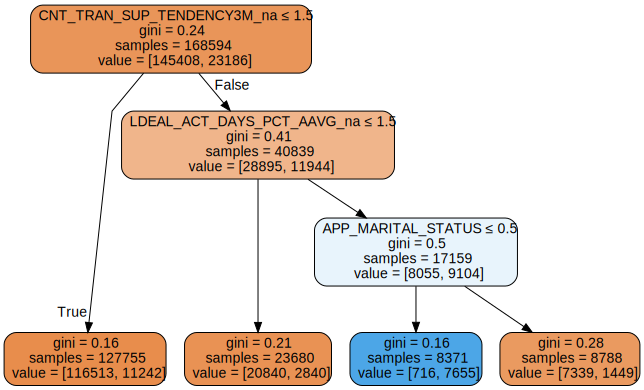

In [37]:
draw_tree(m, to.train.xs, size=10, leaves_parallel=True, precision=2)

The top node represents the initial model before any splits have been done, when all the data is in one group. This is the simplest possible model. It is the result of asking zero questions and will always predict the value to be the average value of the whole dataset.

In this case, we can see it predicts a values of [261123, 23029] for the logarithm of the sales price. It gives a mean squared error of 0.48. The square root of this is 0.69. (Remember that unless you see m_rmse, or a root mean squared error, then the value you are looking at is before taking the square root, so it is just the average of the square of the differences.) We can also see that there are 404,710 auction records in this group—that is the total size of our training set. The final piece of information shown here is the decision criterion for the best split that was found, which is to split based on the coupler_system column.

In [38]:
m_accuracy(m, to.train.xs, to.train.ys)

0.9036323949844004

In [39]:
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=24, min_samples_split=5, n_estimators=250)

# Define parameter grids using list comprehensions and numpy functions
n_estimators = [200, 250]
max_features = ['log', 'sqrt']
max_depth = [16, 24]
min_samples_split = [5, 10]

parameter_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
}

grid_search = GridSearchCV(rf_model, parameter_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(to.train.xs, to.train.ys.iloc[:, 0])

best_rf_model = grid_search.best_estimator_

# Evaluate
rf_predictions = best_rf_model.predict(to.valid.xs)
rf_accuracy = accuracy_score(to.valid.ys.iloc[:, 0], rf_predictions)
rf_auc = roc_auc_score(to.valid.ys.iloc[:, 0], rf_predictions)

KeyboardInterrupt: 

In [ ]:
best_rf_model = grid_search.best_estimator_

# Evaluate
rf_predictions = best_rf_model.predict(to.valid.xs)
rf_accuracy = accuracy_score(to.valid.ys.iloc[:, 0], rf_predictions)
rf_auc = roc_auc_score(to.valid.ys.iloc[:, 0], rf_predictions)
rf_accuracy, rf_auc

(0.9264971054379805, 0.7362643957208549)

In [ ]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=24, min_samples_split=5, n_estimators=250,
                       n_jobs=-1, random_state=42)

In [40]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=24, min_samples_split=5, n_estimators=250)
rf_model.fit(to.train.xs, to.train.ys.iloc[:, 0])


# Evaluate
rf_predictions = rf_model.predict(to.valid.xs)
rf_accuracy = accuracy_score(to.valid.ys.iloc[:, 0], rf_predictions)
rf_auc = roc_auc_score(to.valid.ys.iloc[:, 0], rf_predictions)

In [41]:
update_summary_table(
    approach='Random Forest',
    lib='sklearn',
    accuracy=rf_accuracy,
    auc=rf_auc
)

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),sklearn,Naive Classifier,N/A,0.919409,0.5
1,Random Forest,sklearn,Random Forest,Optimized via Grid Search,0.927067,0.735633
2,Scikit-learn (MLPClassifier),Scikit-learn,MLPClassifier,Default / Custom Settings,To be filled,To be filled
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,To be filled,To be filled
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,To be filled,To be filled
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


### 3.3 MLP Classifier Implementation

In [42]:
from sklearn.neural_network import MLPClassifier

class MyMLPClassifier:
    def __init__(self, max_iter):
        #
        self.model = MLPClassifier(**{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,50), 'learning_rate': 'adaptive', 'solver': 'adam'},  max_iter=max_iter, random_state=42, verbose=True)

    def train(self, X, y):
        self.model.fit(X, y)

    def evaluate(self, X, y):
        predictions = self.model.predict(X)
        accuracy = accuracy_score(y, predictions)
        auc = roc_auc_score(y, predictions)
        return accuracy, auc

mlp_classifier = MyMLPClassifier(max_iter=50)
mlp_classifier.train(to.train.xs, to.train.ys)
mlp_accuracy, mlp_auc = mlp_classifier.evaluate(to.valid.xs, to.valid.ys)
mlp_accuracy, mlp_auc

Iteration 1, loss = 1.23055935
Iteration 2, loss = 0.78097790
Iteration 3, loss = 0.64262621
Iteration 4, loss = 0.50511707
Iteration 5, loss = 0.46760700
Iteration 6, loss = 0.43725800
Iteration 7, loss = 0.41189475
Iteration 8, loss = 0.38568996
Iteration 9, loss = 0.39639883
Iteration 10, loss = 0.34081024
Iteration 11, loss = 0.32931945
Iteration 12, loss = 0.33517582
Iteration 13, loss = 0.32570723
Iteration 14, loss = 0.29882090
Iteration 15, loss = 0.30051109
Iteration 16, loss = 0.29537170
Iteration 17, loss = 0.29221959
Iteration 18, loss = 0.28650754
Iteration 19, loss = 0.28243285
Iteration 20, loss = 0.27788678
Iteration 21, loss = 0.27742489
Iteration 22, loss = 0.27091519
Iteration 23, loss = 0.27180327
Iteration 24, loss = 0.26263573
Iteration 25, loss = 0.26954474
Iteration 26, loss = 0.26001877
Iteration 27, loss = 0.25698312
Iteration 28, loss = 0.26656896
Iteration 29, loss = 0.25449626
Iteration 30, loss = 0.25788306
Iteration 31, loss = 0.25089459
Iteration 32, los

(0.9187861820252444, 0.741187917080238)

In [43]:
update_summary_table(
    approach='Scikit-learn (MLPClassifier)',
    lib='sklearn',
    accuracy=mlp_accuracy,
    auc=mlp_auc
)

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),sklearn,Naive Classifier,N/A,0.919409,0.5
1,Random Forest,sklearn,Random Forest,Optimized via Grid Search,0.927067,0.735633
2,Scikit-learn (MLPClassifier),sklearn,MLPClassifier,Default / Custom Settings,0.918786,0.741188
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,To be filled,To be filled
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,To be filled,To be filled
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


###  3.4 Keras

In [44]:
import keras
import keras_tuner
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

keras.utils.set_random_seed(42)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
print("Number of accelerators: ", strategy.num_replicas_in_sync)

def build_model(hp, opt=None):
    input_features = to.train.xs.shape[1]
    with strategy.scope():
        model = Sequential()


        model.add(Dense(
            units=hp.Int('units_0' , min_value=256, max_value=2048, step=64),
            use_bias=True,
            activation='relu',
            input_shape=(input_features,)))
        model.add(Dropout(hp.Float(f"dropout_rate_0", min_value=0, max_value=0.6, step=0.2)))


        # Dense layers with Batch Normalization and ReLU
        for i in range(1, hp.Int('num_layers', min_value=6, max_value=12)):
            model.add(BatchNormalization())
            model.add(Dense(units=hp.Int('units_' + str(i), min_value=256, max_value=2048, step=512),
                            use_bias=True,
                            kernel_regularizer=l2(0.01)))
            model.add(Activation('relu'))
            model.add(Dropout(hp.Float(f"dropout_rate_{i}", min_value=0, max_value=0.6, step=0.2)))


        # Output layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        optimizer = opt if opt is not None else Adam(hp.Float('lr', min_value=1e-4, max_value=1e-2, sampling='LOG'))
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['AUC']
        )
    return model

Num GPUs Available:  1
Number of accelerators:  1


In [45]:
# Hyperparameter tuning setup
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective=keras_tuner.Objective("val_auc", direction="max"),
    max_trials=5,
    executions_per_trial=1,
    overwrite=False,
    directory="/kaggle/working/",
    project_name="hyperparameter_tuning",
    seed=42
)

# Start hyperparameter tuning
tuner.search_space_summary()

early_stopping = keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, min_delta=1e-3, restore_best_weights=True)

# Assuming X_train, y_train, X_test, y_test, and BATCH_SIZE are defined and valid
tuner.search(to.train.xs, to.train.ys, validation_data=(to.valid.xs, to.valid.ys), epochs=50, batch_size=1024, callbacks=[early_stopping])

# Display results
tuner.results_summary()

Trial 6 Complete [00h 01m 38s]
val_auc: 0.6184189319610596

Best val_auc So Far: 0.8770265579223633
Total elapsed time: 00h 17m 43s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
320               |896               |units_0
0.2               |0                 |dropout_rate_0
6                 |8                 |num_layers
256               |768               |units_1
0                 |0                 |dropout_rate_1
256               |1280              |units_2
0.4               |0                 |dropout_rate_2
768               |1792              |units_3
0.4               |0.4               |dropout_rate_3
1792              |1792              |units_4
0.2               |0.4               |dropout_rate_4
768               |256               |units_5
0.4               |0                 |dropout_rate_5
0.00077254        |0.00036238        |lr
256               |1792              |units_6
0.4               |0.4               |dropout_rate_6
1792 

KeyboardInterrupt: 

In [46]:
best_hps = tuner.get_best_hyperparameters(1)[0]
best_hps.values

{'units_0': 896,
 'dropout_rate_0': 0.0,
 'num_layers': 8,
 'units_1': 768,
 'dropout_rate_1': 0.0,
 'units_2': 1280,
 'dropout_rate_2': 0.0,
 'units_3': 1792,
 'dropout_rate_3': 0.4,
 'units_4': 1792,
 'dropout_rate_4': 0.4,
 'units_5': 256,
 'dropout_rate_5': 0.0,
 'lr': 0.0003623815491328145,
 'units_6': 1792,
 'dropout_rate_6': 0.4,
 'units_7': 768,
 'dropout_rate_7': 0.0,
 'units_8': 256,
 'dropout_rate_8': 0.4,
 'units_9': 1792,
 'dropout_rate_9': 0.0}

In [66]:
best_hps_values = best_hps.values
file_path = 'best_hps_values.pkl'

with open(file_path, 'wb') as f:
    pickle.dump(best_hps_values, f)

with open('ds,pkl', 'wb') as f:
    pickle.dump((to.train.xs, to.train.ys, to.valid.xs, to.valid.ys), f)


print(f'Best hyperparameter values saved in {file_path}')

Best hyperparameter values saved in best_hps_values.pkl


In [48]:
keras_model = build_model(best_hps)
history = keras_model.fit(to.train.xs, to.train.ys, validation_data=(to.valid.xs, to.valid.ys), epochs=22, batch_size=1024)

Epoch 1/50
330/330 [==============================] - 13s 20ms/step - loss: 13.5656 - auc: 0.7469 - val_loss: 0.6825 - val_auc: 0.6128
Epoch 2/50
330/330 [==============================] - 6s 19ms/step - loss: 0.4228 - auc: 0.7930 - val_loss: 0.4481 - val_auc: 0.7626
Epoch 3/50
330/330 [==============================] - 6s 18ms/step - loss: 0.3709 - auc: 0.7945 - val_loss: 0.3975 - val_auc: 0.7751
Epoch 4/50
330/330 [==============================] - 6s 19ms/step - loss: 0.3558 - auc: 0.7929 - val_loss: 0.9160 - val_auc: 0.6454
Epoch 5/50
330/330 [==============================] - 6s 19ms/step - loss: 0.3437 - auc: 0.7974 - val_loss: 0.3879 - val_auc: 0.7945
Epoch 6/50
330/330 [==============================] - 6s 17ms/step - loss: 0.3526 - auc: 0.8042 - val_loss: 0.4001 - val_auc: 0.7741
Epoch 7/50
330/330 [==============================] - 6s 19ms/step - loss: 0.3414 - auc: 0.8163 - val_loss: 0.4645 - val_auc: 0.7214
Epoch 8/50
330/330 [==============================] - 6s 18ms/step 

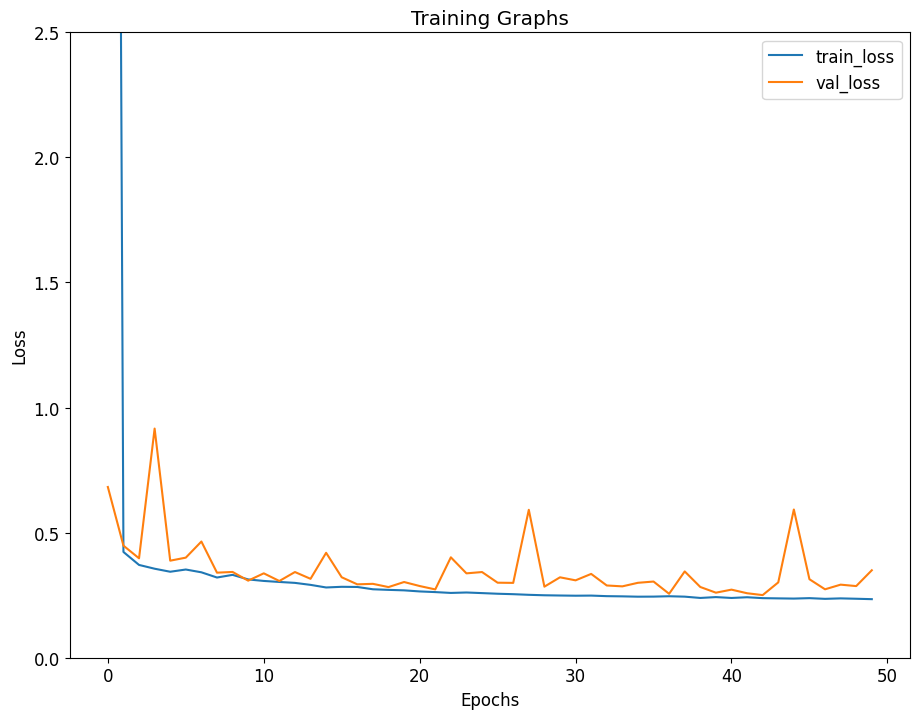

In [49]:
(fig, ax) = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(history.history["loss"], label="train_loss")
ax.plot(history.history["val_loss"], label="val_loss")
ax.set_title("Training Graphs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_ylim([0, 2.5])
ax.legend()

fig.tight_layout(pad=3.0)
fig.show()

In [50]:
from sklearn.metrics import roc_auc_score, accuracy_score

validation_probs = keras_model.predict(to.valid.xs)
validation_preds = (validation_probs > 0.5).astype(int)

keras_auc = roc_auc_score(to.valid.ys, validation_probs)
keras_acc = accuracy_score(to.valid.ys, validation_preds)

print(f'Keras AUC: {keras_auc}')
print(f'Keras Accuracy: {keras_acc}')

keras_acc, keras_auc


1318/1318 [==============================] - 3s 2ms/step
Keras AUC: 0.8456895862279379
Keras Accuracy: 0.8931384644585746


(0.8931384644585746, 0.8456895862279379)

In [51]:
update_summary_table(
    approach='Keras (TensorFlow)',
    lib='TensorFlow',
    accuracy=keras_acc,
    auc=keras_auc
)

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),sklearn,Naive Classifier,N/A,0.919409,0.5
1,Random Forest,sklearn,Random Forest,Optimized via Grid Search,0.927067,0.735633
2,Scikit-learn (MLPClassifier),sklearn,MLPClassifier,Default / Custom Settings,0.918786,0.741188
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,0.893138,0.84569
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,To be filled,To be filled
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


### 3.5 TensorFlow Approach

In [52]:
xs, ys = tf.convert_to_tensor(to.train.xs, dtype=tf.float32), tf.convert_to_tensor(to.train.ys, dtype=tf.float32)
xs_valid, ys_valid = tf.convert_to_tensor(to.valid.xs, dtype=tf.float32), tf.convert_to_tensor(to.valid.ys, dtype=tf.float32)

xs.shape, ys.shape, xs_valid.shape, ys_valid.shape

(TensorShape([168594, 163]),
 TensorShape([168594, 1]),
 TensorShape([42148, 163]),
 TensorShape([42148, 1]))

In [53]:
BATCH_SIZE = 1024
train_ds = tf.data.Dataset.from_tensor_slices((xs, ys))
train_ds = train_ds.shuffle(buffer_size=xs.shape[0]).batch(BATCH_SIZE)

valid_ds = tf.data.Dataset.from_tensor_slices((xs_valid, ys_valid))
valid_ds = valid_ds.shuffle(buffer_size=xs_valid.shape[0]).batch(BATCH_SIZE)

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses, metrics

In [55]:
model = tf.keras.Sequential()
for i in range(best_hps_values['num_layers']):
    print(best_hps_values['units_%d' % (i)])
    model.add(BatchNormalization())
    model.add(layers.Dense(best_hps_values['units_%d' % (i)], activation=tf.nn.relu, kernel_regularizer=l2(0.01)))
    model.add(layers.Dropout(best_hps_values['dropout_rate_%d' % (i)]))
model.add(layers.Dense(1, activation=tf.nn.sigmoid))

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=best_hps_values['lr']),
                loss=losses.BinaryCrossentropy(),
                metrics=['accuracy', 'AUC'])

896
768
1280
1792
1792
256
1792
768


In [56]:
model.build(input_shape=xs.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Ba  (168594, 163)             652       
 tchNormalization)                                               
                                                                 
 dense_16 (Dense)            (168594, 896)             146944    
                                                                 
 dropout_14 (Dropout)        (168594, 896)             0         
                                                                 
 batch_normalization_13 (Ba  (168594, 896)             3584      
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (168594, 768)             688896    
                                                                 
 dropout_15 (Dropout)        (168594, 768)            

In [57]:
_ = model.fit(xs, ys, batch_size=1024, epochs=30, validation_data=(xs_valid, ys_valid))

Epoch 1/30
165/165 [==============================] - 11s 34ms/step - loss: 24.4617 - accuracy: 0.9071 - auc: 0.8247 - val_loss: 3.4465 - val_accuracy: 0.8638 - val_auc: 0.5013
Epoch 2/30
165/165 [==============================] - 5s 30ms/step - loss: 1.1481 - accuracy: 0.9241 - auc: 0.8630 - val_loss: 0.5719 - val_accuracy: 0.8638 - val_auc: 0.5385
Epoch 3/30
165/165 [==============================] - 5s 31ms/step - loss: 0.3259 - accuracy: 0.9243 - auc: 0.8658 - val_loss: 0.4258 - val_accuracy: 0.8655 - val_auc: 0.8322
Epoch 4/30
165/165 [==============================] - 5s 30ms/step - loss: 0.2967 - accuracy: 0.9238 - auc: 0.8670 - val_loss: 0.3081 - val_accuracy: 0.9148 - val_auc: 0.8814
Epoch 5/30
165/165 [==============================] - 5s 32ms/step - loss: 0.2759 - accuracy: 0.9251 - auc: 0.8735 - val_loss: 0.3601 - val_accuracy: 0.8707 - val_auc: 0.8687
Epoch 6/30
165/165 [==============================] - 5s 29ms/step - loss: 0.2726 - accuracy: 0.9249 - auc: 0.8765 - val_lo

In [58]:
def loss_fn(y_true, y_pred):  # Use clearer variable names
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_mean(loss)

def one_batch(model, x_batch, y_batch, loss_func, optimizer=None, is_train=False):  # Rename to train_step
    if is_train == True:
        with tf.GradientTape() as tape:
            y_pred = model(x_batch, training=True)
            loss = loss_func(y_batch, y_pred)

        gradients = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(gradients, model.variables))
    else:
        y_pred = model(x_batch, training=False)
        loss = loss_func(y_batch, y_pred)

    return loss

def train_model(model, train_dataset, val_dataset, optimizer, loss_func, epochs=10):  # Use 'val' for validation
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        train_epoch_loss = tf.keras.metrics.Mean()  # Track epoch-wise loss
        val_epoch_loss = tf.keras.metrics.Mean()

        for x_batch, y_batch in train_dataset:
            train_batch_loss = one_batch(model, x_batch, y_batch, loss_func, optimizer=optimizer, is_train=True)
            train_epoch_loss.update_state(train_batch_loss)

        for x_batch, y_batch in val_dataset:
            val_batch_loss = one_batch(model, x_batch, y_batch, loss_func)
            val_epoch_loss.update_state(val_batch_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Training loss: {train_epoch_loss.result():.4f}, Validation loss: {val_epoch_loss.result():.4f}")

        train_losses.append(train_epoch_loss.result())
        val_losses.append(val_epoch_loss.result())

    return train_losses, val_losses


In [ ]:
train_losses, val_losses = train_model(
    model,
    train_ds,
    valid_ds,
    optimizer=tf.optimizers.Adam(learning_rate=0.001,weight_decay=0.1),
    loss_func=loss_fn
)

Epoch 1/10 - Training loss: 0.2117, Validation loss: 0.2522
Epoch 2/10 - Training loss: 0.2070, Validation loss: 0.2296
Epoch 3/10 - Training loss: 0.2062, Validation loss: 0.2202
Epoch 4/10 - Training loss: 0.2051, Validation loss: 0.2394
Epoch 5/10 - Training loss: 0.2034, Validation loss: 0.2109
Epoch 6/10 - Training loss: 0.2030, Validation loss: 0.2291
Epoch 7/10 - Training loss: 0.2023, Validation loss: 0.2192
Epoch 8/10 - Training loss: 0.2012, Validation loss: 0.2304
Epoch 9/10 - Training loss: 0.2005, Validation loss: 0.2352
Epoch 10/10 - Training loss: 0.2001, Validation loss: 0.2192


In [59]:
validation_probs = model(xs_valid, training=False)
validation_preds = (validation_probs > 0.5).numpy().astype('int')

tensorflow_auc = roc_auc_score(ys_valid, validation_probs)
tensorflow_acc = accuracy_score(ys_valid, validation_preds)

print('Tensorflow AUC:', tensorflow_auc)
print('Tensorflow ACC:', tensorflow_acc)

tensorflow_acc, tensorflow_auc

Tensorflow AUC: 0.8982249189788292
Tensorflow ACC: 0.8737781152130587


(0.8737781152130587, 0.8982249189788292)

In [60]:
update_summary_table(
    approach='TensorFlow',
    lib='TensorFlow',
    accuracy=tensorflow_acc,
    auc=tensorflow_auc
)

,Approach,Library Used,Algorithm,Hyperparameters,Accuracy,AUC Score
0,Baseline (Naive Classifier),sklearn,Naive Classifier,N/A,0.919409,0.5
1,Random Forest,sklearn,Random Forest,Optimized via Grid Search,0.927067,0.735633
2,Scikit-learn (MLPClassifier),sklearn,MLPClassifier,Default / Custom Settings,0.918786,0.741188
3,Keras (TensorFlow),TensorFlow,Keras Neural Network,Custom Settings,0.893138,0.84569
4,TensorFlow,TensorFlow,TensorFlow Neural Network,Custom Settings,0.873778,0.898225
5,NumPy,NumPy,Custom Neural Network,Custom Implementation,To be filled,To be filled


### Most sofisticated Neural network

SuggestedLRs(valley=0.004365158267319202)

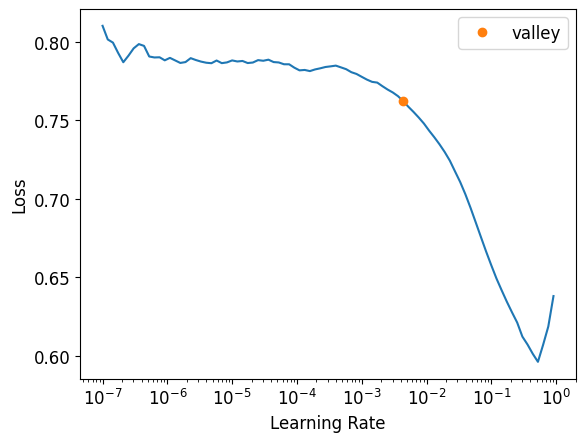

In [61]:
layers = [64, 128, 64]
metrics = [accuracy,RocAucBinary()]
dls = to.dataloaders(shuffle_train=True, device=torch.device('cuda'), bs=512)

# learn = tabular_learner(dls, layers=layers, metrics=metrics, config=tabular_config(ps=0.4))
learn = tabular_learner(dls, layers=layers, metrics=metrics, config=tabular_config(ps=0.4), wd=0.1)
learn.model.to('cuda')

learn.lr_find()

In [62]:
learn.fit(n_epoch=4, lr=0.001)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.253100,0.231323,0.926900,0.866965,00:09
1,0.230019,0.221585,0.929321,0.879397,00:10
2,0.224316,0.216132,0.930175,0.889140,00:12
3,0.218649,0.215546,0.930602,0.891238,00:17


SuggestedLRs(valley=0.0003981071640737355)

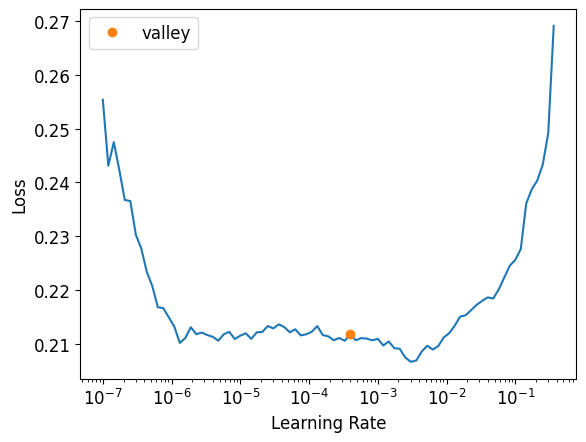

In [63]:
learn.lr_find()

In [64]:
learn.fit_one_cycle(n_epoch=6, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.209983,0.217842,0.930388,0.889726,00:15
1,0.208849,0.213044,0.930602,0.892062,00:10
2,0.208840,0.216931,0.930625,0.891066,00:14
3,0.209198,0.219596,0.930530,0.887759,00:26
4,0.209525,0.214642,0.930649,0.892280,00:12
5,0.205919,0.212438,0.930412,0.891917,00:09


In [65]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(14, 7)
    (1): Embedding(9, 5)
    (2): Embedding(6, 4)
    (3): Embedding(5, 4)
    (4): Embedding(11701, 304)
    (5): Embedding(3, 3)
    (6): Embedding(13, 7)
    (7-8): 2 x Embedding(3, 3)
    (9-11): 3 x Embedding(5, 4)
    (12): Embedding(12, 6)
    (13-71): 59 x Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(91, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=626, out_features=64, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplace=False)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=64, out_features=128, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Dropout(p=0.4, inplac